StudentID: 2021111114

Name: Jiahang Zhang

Date: 4/4/2024

Environment: Python3

*为保持逻辑完整，对任务顺序做出了一定调整。*

# 1.回归方程提炼

我们结合企业经营知识做出假设：对于大部分上市公司而言，营收增长率（或利润增长率）是观察企业成长速度和发展潜力的最直观因素，作为因变量。而公司规模和市场类型是对公司基本面分析的基础，因此作为自变量。同时，我们提出观点：研发投入(R&D)是影响科创企业成长的核心因素。

综合以上假设与观点，得到以下模型：

$$\text{Sales Growth} = \beta_0 + \beta_1 \cdot \text{R&D Intensity} + \beta_2 \cdot \text{FirmSize} + \beta_3 \cdot \text{MarketType} + \epsilon$$

其中，公司规模用总资产表示，市场类型采用中证行业类型（2021），为了便于回归，我们按如下表格进行映射。

| 行业     | 映射数值 |
|----------|----------|
| 工业     | 1        |
| 医药卫生 | 2        |
| 信息技术 | 3        |
| 原材料   | 4        |
| 通信服务 | 5        |
| 可选消费 | 6        |
| 能源     | 7        |
| 主要消费 | 8        |


# 2.数据选择与数据描述

结合以上分析，从同花顺iFind终端的企业数据浏览器下载数据，从科创版中进行选取，检索指标包括证券代码、公司名称、所属中证行业（2021）、研发投入总额占营业收入比例（2022）、资产共计（2022）。这里选取2022年报是为了保证数据的完整性，因为部分公司尚未发布2023年财务年报。

- 数据优点：数据量大，删去缺省值后数据可达500条以上；
- 数据缺点：科创版所含企业规模都达到一定程度，可能忽略部分初创公司，而这会削弱研发费用影响的显著性；
- 适用性：总的来看，选取数据较为适合所研究问题。

In [90]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

%matplotlib inline

# 读取数据
data = pd.read_csv("E:/jupyter/HW3.csv")
data.columns = data.columns.str.strip()
# 删除包含缺失值的行
data = data.dropna()

In [82]:

print(data.describe())


print(data.corr())

       GrowthRate  MarketType  R&Dintensity       FirmSize
count  562.000000  562.000000    562.000000     562.000000
mean    22.243274    2.320285     17.816868    5261.539609
std     59.547090    1.329997     27.517435   16017.705352
min    -75.940000    1.000000      0.980000     355.560000
25%     -2.920000    1.000000      6.660000    1406.472500
50%     12.860000    2.000000     10.525000    2160.125000
75%     34.665000    3.000000     19.257500    4209.650000
max    661.330000    8.000000    323.730000  305103.690000
              GrowthRate  MarketType  R&Dintensity  FirmSize
GrowthRate      1.000000   -0.115617      0.110611  0.113525
MarketType     -0.115617    1.000000      0.053829 -0.034272
R&Dintensity    0.110611    0.053829      1.000000 -0.030707
FirmSize        0.113525   -0.034272     -0.030707  1.000000


经过上述简单统计，发现增长率可能与研发强度、公司规模之间有一定的正向相关性。

# 3.OLS回归及其基本假设验证

In [83]:

# 添加常数列
data['const'] = 1

# 定义自变量和因变量
X = data[['R&Dintensity', 'FirmSize', 'MarketType', 'const']]
y = data['GrowthRate']

# 执行OLS回归
model = sm.OLS(y, X)
results = model.fit()

# 打印回归结果
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             GrowthRate   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.718
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           4.65e-05
Time:                        23:40:37   Log-Likelihood:                -3082.3
No. Observations:                 562   AIC:                             6173.
Df Residuals:                     558   BIC:                             6190.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
R&Dintensity     0.2607      0.090      2.898   

在讨论之前，先说明上述OLS回归满足基本假设：

In [84]:
# 同方差性检验
print("同方差性检验：")
# Breusch-Pagan检验
bp_test = het_breuschpagan(results.resid, results.model.exog)
print("Breusch-Pagan检验p值:", bp_test[1])
# White检验
white_test = het_white(results.resid, results.model.exog)
print("White检验p值:", white_test[1],'\n')

# 自相关性检验
print("自相关性检验：")
# Durbin-Watson检验
print("Durbin-Watson统计量:", sm.stats.stattools.durbin_watson(results.resid),'\n')

# 多重共线性检验
print("多重共线性检验：")
# 计算方差膨胀因子(VIF)
vif = pd.DataFrame()
vif["Variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

同方差性检验：
Breusch-Pagan检验p值: 1.2695243963853061e-08
White检验p值: 4.636872975513286e-08 

自相关性检验：
Durbin-Watson统计量: 1.9408493325691207 

多重共线性检验：
      Variables       VIF
0  R&Dintensity  1.003746
1      FirmSize  1.002014
2    MarketType  1.003978
3         const  4.520930


模型的残差项之间不存在显著的自相关性，自变量之间也没有显著的多重共线性问题，这表明OLS模型满足了自相关性和多重共线性两个基本假设，但同方差性检验的结果显示存在一定的异方差性问题。

# 4.讨论

1. 研发投入（R&Dintensity）的影响：

R&Dintensity（研发强度）的系数为0.2607，P值为0.004，说明研发投入（R&Dintensity）对科创企业的成长有积极影响，这与观点一致，表明研发投入是影响科创企业成长的核心因素。
同时，公司规模对科创企业成长具有显著的正向影响，这与常识相符，通常情况下，规模较大的企业更容易实现较高的成长率。

2. 潜在问题和漏洞：
- 回归模型的R-squared值较低（仅为0.040），这意味着模型解释了很小一部分因变量的方差，有可能存在其他未被考虑到的重要因素。
- 模型存在一定的异方差性问题。

3. 改进方案：
- 尝试增加更多的控制变量，以更准确地捕捉影响科创企业成长的因素。
- 通过收集更多的数据，尤其是长期数据和包括初创企业地数据，来更全面地分析研发投入与企业成长之间的关系。
- 使用更复杂的模型，如面板数据模型或者结构方程模型，来更好地解释变量之间的关系。

# 附录

本部分对数据进行一些有趣的数据分析，便于更全面地了解数据库中的初创企业

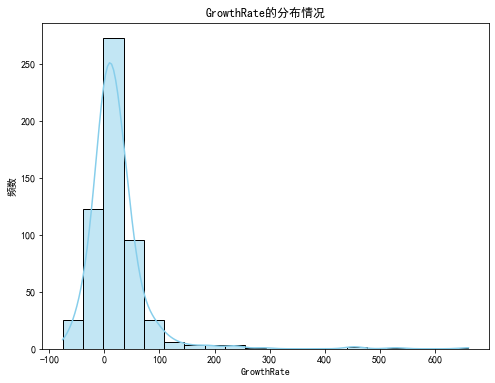

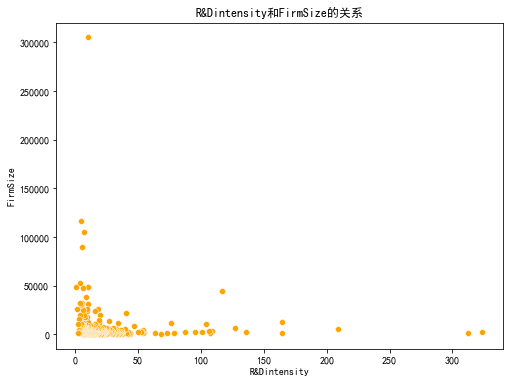

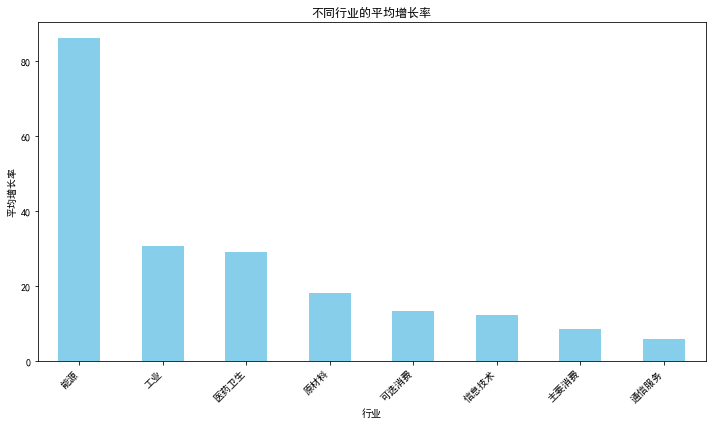

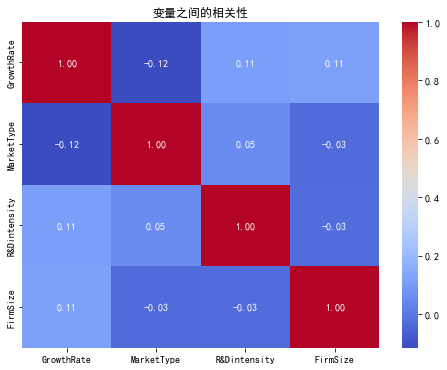

<Figure size 720x432 with 0 Axes>

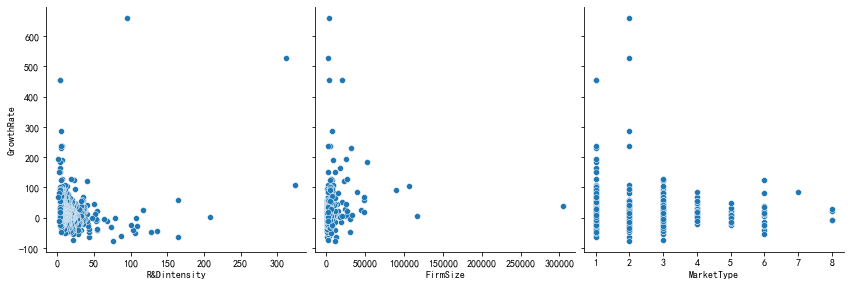

In [91]:

import seaborn as sns

# 读取数据
data = pd.read_csv("E:/jupyter/HW3.csv")

# 去除列名中的空格
data.columns = data.columns.str.strip()

# 1. 探索GrowthRate的分布情况
plt.figure(figsize=(8, 6))
sns.histplot(data['GrowthRate'], bins=20, kde=True, color='skyblue')
plt.title('GrowthRate的分布情况')
plt.xlabel('GrowthRate')
plt.ylabel('频数')
plt.show()

# 2. 分析R&Dintensity和FirmSize的关系
plt.figure(figsize=(8, 6))
sns.scatterplot(x='R&Dintensity', y='FirmSize', data=data, color='orange')
plt.title('R&Dintensity和FirmSize的关系')
plt.xlabel('R&Dintensity')
plt.ylabel('FirmSize')
plt.show()

# 3. 研究不同行业的平均增长率
industry_mapping = {
    1: '工业',
    2: '医药卫生',
    3: '信息技术',
    4: '原材料',
    5: '通信服务',
    6: '可选消费',
    7: '能源',
    8: '主要消费'
}
data['Industry'] = data['MarketType'].map(industry_mapping)
industry_growth = data.groupby('Industry')['GrowthRate'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
industry_growth.plot(kind='bar', color='skyblue')
plt.title('不同行业的平均增长率')
plt.xlabel('行业')
plt.ylabel('平均增长率')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. 检查变量之间的相关性
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('变量之间的相关性')
plt.show()

# 5. 探索GrowthRate与其他变量之间的关系
plt.figure(figsize=(10, 6))
sns.pairplot(data, x_vars=['R&Dintensity', 'FirmSize', 'MarketType'], y_vars=['GrowthRate'], kind='scatter', height=4)
plt.show()
